In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive')
myPath = '/content/drive/MyDrive/PES/python-notebooks/1-quantization'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Download lib:
http://www.dilloneng.com/uploads/2/1/2/2/21220816/demodel-0.2.tar.gz


In [ ]:
from __future__ import division
import numpy as np
import math
import scipy.signal as sig
from scipy.fftpack import fft, ifft, fftshift
import matplotlib.pyplot as plt
!pip install fixedpoint
from fixedpoint import FixedPoint

M,N = 10,3
# M = Bits enteros, N = Bits fraccionarios

a_fp = 2.61231231241
b_fp = -1.54
a_fx = FixedPoint(a_fp,n=N,m=M)
b_fx = FixedPoint(b_fp,n=N,m=M)

print (a_fx.qformat)
print (float(a_fx))
print (float(b_fx))


def fixedToFloat(array):
  result = []
  for num in array:
    result.append(float(num))
  return result

def arrayFixedPointValue(initial_value, fx_array_len, qformat):
  # Retorna: un array con initial_value en todas sus posiciones, de longitud
  # fx_array_len, con el formato qformat = {'signed': ?, 'm': ?, 'n': ?}
  fx_type = FixedPoint(initial_value, **qformat)
  fx_array = [fx_type for _ in range(fx_array_len)]
  return fx_array

def arrayFixedPoint(initial_array, qformat):
  # Retorna: un array con los valores de initial_array convertidos
  # a fixed point, de la misma longitud
  # con el formato qformat = {'signed': ?, 'm': ?, 'n': ?}
  fx_array = []
  for num in initial_array:
    fx_num = FixedPoint(num, **qformat)
    fx_array.append(fx_num)
  return fx_array

# Quiero hacer un array de fixedpoint
qformat = {'signed': True, 'm': 1, 'n': 4}
fx_array = arrayFixedPointValue(0,10,qformat)
print(fixedToFloat(fx_array))





UQ10.3
2.625
-1.5
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


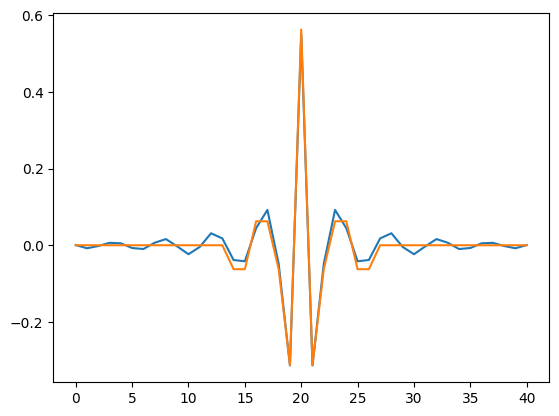

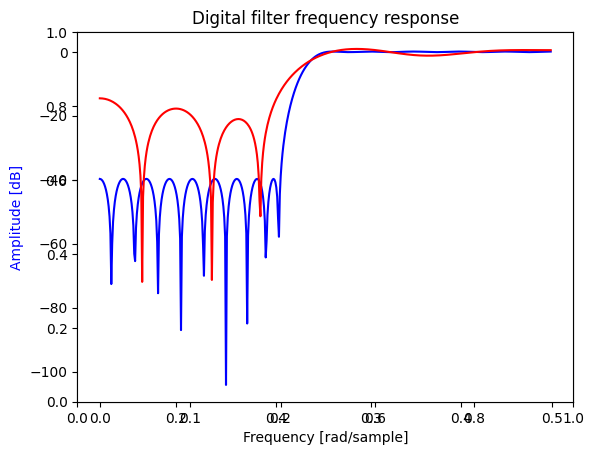

In [ ]:
# Ejemplo filtro pasa altos

qformat = {'signed': True, 'm': 4, 'n': 4}

c = sig.remez(41, [0, 0.2, 0.25, 0.5], [0, 1],maxiter=100)
# Array de fixedpoint, pasandole un array y el formato:
c_fx2 = arrayFixedPoint(c, qformat)

plt.plot (c)
plt.plot (c_fx2)

w, h = sig.freqz(c)
w_fx, h_fx = sig.freqz(c_fx2)
w = w/(2*np.pi)
fig = plt.figure()
plt.title('Digital filter frequency response')
ax1 = fig.add_subplot(111)
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')
plt.plot(w, 20 * np.log10(abs(h_fx)), 'r')

plt.show()



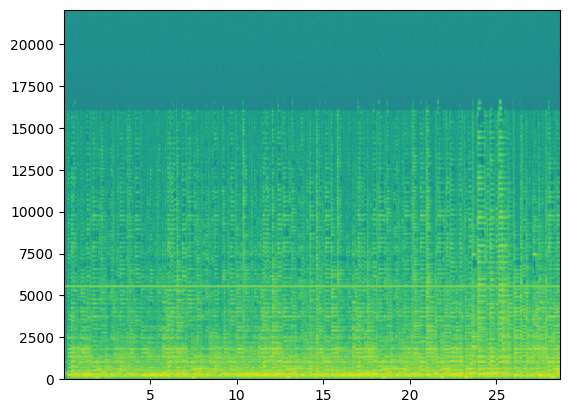

In [ ]:
import scipy.io.wavfile
from scipy import signal
input_rate,audio=scipy.io.wavfile.read(myPath+'/audio_samples/classical_gas.wav')
Fs= input_rate
con_len=-1
audio_ch = audio[:con_len,0]
N= len(audio_ch)
t = np.arange(0, N/Fs, 1/Fs)
Fn = Fs/8
noise = 200*np.sin(2*np.pi*Fn*t) # Noise

Pxx, freqs, bins, im = plt.specgram((audio_ch+noise), NFFT=1024, Fs=Fs, noverlap=900)
plt.show()


In [ ]:
out=(audio_ch+noise)/np.max(np.abs(audio_ch+noise))
scipy.io.wavfile.write(myPath+'/out_with_noise.wav',Fs,out)

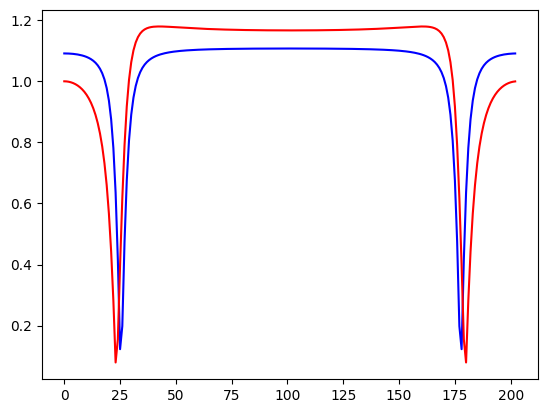

In [ ]:
h = np.array([1, -1.414, 1,1.273,-0.81])
qformat = {'signed': True, 'm': 2, 'n': 2}
h_fxv = arrayFixedPoint(h, qformat)


def notch_filter_ideal (signal):
    zeros = np.zeros(2)
    x = np.concatenate((zeros,signal), axis=0)
    y = np.zeros(len(signal)+2)
    for i in range (len(signal)):
        n = i+2 # Solo para facilitar la escritura
        #y[n] = h_fxv[0] * x[n] + h_fxv[1]* x[n-1] + h_fxv[2] * x[n-2] + h_fxv[3] * y[n-1] + h_fxv[4] * y[n-2]
        y[n] = h[0] * x[n] + h[1]* x[n-1] + h[2] * x[n-2] + h[3] * y[n-1] + h[4] * y[n-2]
    return y

def notch_filter_quant (signal):
    zeros = np.zeros(2)
    x = np.concatenate((zeros,signal), axis=0)
    y = np.zeros(len(signal)+2)
    for i in range (len(signal)):
        n = i+2 # Solo para facilitar la escritura
        y[n] = h_fxv[0] * x[n] + h_fxv[1]* x[n-1] + h_fxv[2] * x[n-2] + h_fxv[3] * y[n-1] + h_fxv[4] * y[n-2]
    return y


zeros = np.zeros(100)
ones = np.ones(1)
dirac = np.concatenate((zeros,ones,zeros),axis=0)
plt.plot(abs(fft(notch_filter_ideal(dirac))),'b')
plt.plot(abs(fft(notch_filter_quant(dirac))),'r')

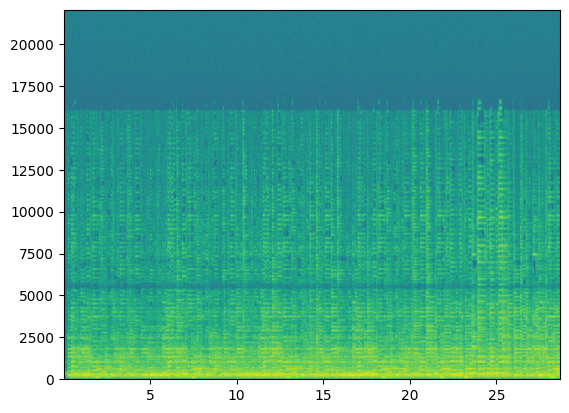

In [ ]:
out2= notch_filter_ideal(audio_ch+noise)
Pxx, freqs, bins, im = plt.specgram((out2), NFFT=1024, Fs=Fs, noverlap=900)
plt.show()

In [ ]:
out2=(out2)/np.max(np.abs(out2))
scipy.io.wavfile.write('out_filtered.wav',Fs,out2)